## Building Vocabulary required for the generator

In [1]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import os

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= 4]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [2]:
dataDir = '/home/bpanoel12'
dataType = 'train2017'

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'captions_{}.json'.format(dataType))

vocab = build_vocab(json=captions_annFile)


loading annotations into memory...
Done (t=2.05s)
creating index...
index created!
[1000/591753] Tokenized the captions.
[2000/591753] Tokenized the captions.
[3000/591753] Tokenized the captions.
[4000/591753] Tokenized the captions.
[5000/591753] Tokenized the captions.
[6000/591753] Tokenized the captions.
[7000/591753] Tokenized the captions.
[8000/591753] Tokenized the captions.
[9000/591753] Tokenized the captions.
[10000/591753] Tokenized the captions.
[11000/591753] Tokenized the captions.
[12000/591753] Tokenized the captions.
[13000/591753] Tokenized the captions.
[14000/591753] Tokenized the captions.
[15000/591753] Tokenized the captions.
[16000/591753] Tokenized the captions.
[17000/591753] Tokenized the captions.
[18000/591753] Tokenized the captions.
[19000/591753] Tokenized the captions.
[20000/591753] Tokenized the captions.
[21000/591753] Tokenized the captions.
[22000/591753] Tokenized the captions.
[23000/591753] Tokenized the captions.
[24000/591753] Tokenized the 

In [3]:
#Saving the vocabulary wrapper
vocab_path = '/home/bpanoel12/vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

Total vocabulary size: 11560
Saved the vocabulary wrapper to '/home/bpanoel12/vocab.pkl'


## Resizing the images to reduce the size and maintaing uniformity over the dataset

In [4]:

def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))


In [9]:
image_dir = '/Users/prannoynoel/Documents/DS/Deep Learning/COCO/fast-ai-coco/train2017'
#output_dir = '/Users/prannoynoel/Documents/DS/Deep Learning/COCO/fast-ai-coco/Resized2017'
image_size = [256, 256]
#resize_images(image_dir, output_dir, image_size)

## Data_loader

In [5]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

## Creating CNN and RNN

In [6]:
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [7]:
re_image_dir = '/home/bpanoel12/images/Resized2017'
caption_path = '/home/bpanoel12/captions_train2017.json'
vocab_path = '/home/bpanoel12/vocab.pkl'

transform = transforms.Compose([ 
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
    
    # Build data loader
data_loader = get_loader(re_image_dir, caption_path, vocab, 
                        transform, 128,
                        shuffle=True, num_workers=2) 


loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


In [8]:
data_loader

## Training the model

In [11]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 1
log_step = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Train the models
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
        if (i+1) % 1000 == 0:
            torch.save(decoder.state_dict(), os.path.join(
                '/home/bpanoel12/images', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                '/home/bpanoel12/images', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        if i == 1010:
            break



Epoch [0/1], Step [0/4624], Loss: 9.3538, Perplexity: 11542.8532
Epoch [0/1], Step [10/4624], Loss: 5.8635, Perplexity: 351.9362
Epoch [0/1], Step [20/4624], Loss: 5.3075, Perplexity: 201.8534
Epoch [0/1], Step [30/4624], Loss: 4.8660, Perplexity: 129.7950
Epoch [0/1], Step [40/4624], Loss: 4.5853, Perplexity: 98.0333
Epoch [0/1], Step [50/4624], Loss: 4.4130, Perplexity: 82.5159
Epoch [0/1], Step [60/4624], Loss: 4.1758, Perplexity: 65.0920
Epoch [0/1], Step [70/4624], Loss: 4.1571, Perplexity: 63.8838
Epoch [0/1], Step [80/4624], Loss: 4.1014, Perplexity: 60.4224
Epoch [0/1], Step [90/4624], Loss: 3.8551, Perplexity: 47.2314
Epoch [0/1], Step [100/4624], Loss: 3.8263, Perplexity: 45.8943
Epoch [0/1], Step [110/4624], Loss: 3.8989, Perplexity: 49.3497
Epoch [0/1], Step [120/4624], Loss: 3.7396, Perplexity: 42.0800
Epoch [0/1], Step [130/4624], Loss: 3.8337, Perplexity: 46.2320
Epoch [0/1], Step [140/4624], Loss: 3.5219, Perplexity: 33.8480
Epoch [0/1], Step [150/4624], Loss: 3.7177, P

In [12]:
from PIL import Image
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

## Testing the model

In [22]:
def test_image(in_image):
    import matplotlib.pyplot as plt
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load('/home/bpanoel12/images/encoder-1-1000.ckpt'))
    decoder.load_state_dict(torch.load('/home/bpanoel12/images/decoder-1-1000.ckpt'))


    image = load_image(in_image, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(in_image)
    plt.imshow(np.asarray(image))

In [24]:
pwd

'/home/bpanoel12'

<start> a bear that is standing in the grass . <end>


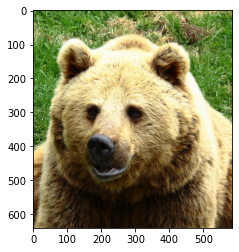

In [25]:
test_image('/home/bpanoel12/images/test_images/000000000285.jpg')

<start> a teddy bear with a stuffed animal on it . <end>


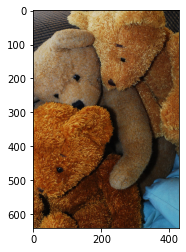

In [26]:
test_image('/home/bpanoel12/images/test_images/000000000776.jpg')

<start> a man on a snowboard in the snow . <end>


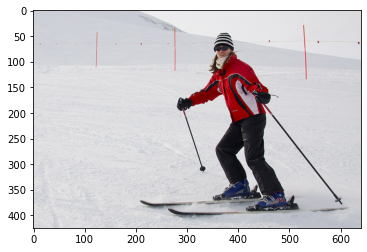

In [27]:
test_image('/home/bpanoel12/images/test_images/000000000785.jpg')

<start> a man is playing tennis on a tennis court . <end>


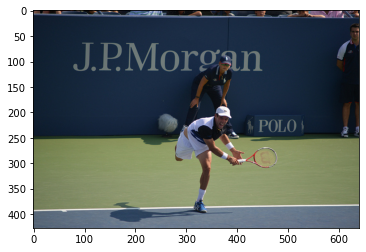

In [28]:
test_image('/home/bpanoel12/images/test_images/000000000885.jpg')

<start> a man riding a wave on a surfboard . <end>


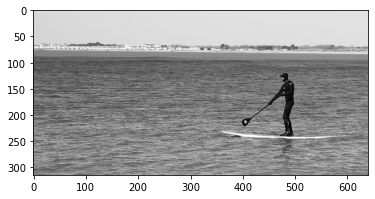

In [29]:
test_image('/home/bpanoel12/images/test_images/000000001490.jpg')

<start> a man is holding a hot dog on a table . <end>


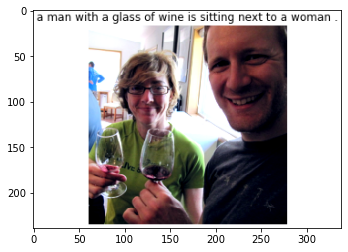

In [30]:
test_image('/home/bpanoel12/images/test_images/1.png')

<start> a zebra standing in a field with a zebra in the background . <end>


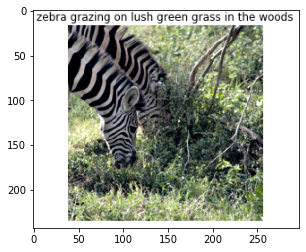

In [31]:
test_image('/home/bpanoel12/images/test_images/2.png')

<start> a large white clock in a room with a window . <end>


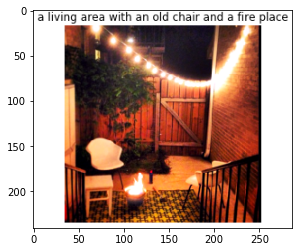

In [32]:
test_image('/home/bpanoel12/images/test_images/3.png')

<start> a man riding a horse on a street with a horse . <end>


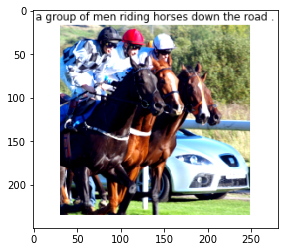

In [33]:
test_image('/home/bpanoel12/images/test_images/5.png')

<start> a large clock on a city street with a large clock on it . <end>


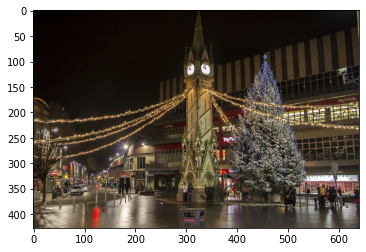

In [34]:
test_image('/home/bpanoel12/images/test_images/')

<start> a giraffe is standing in the grass with a tree . <end>


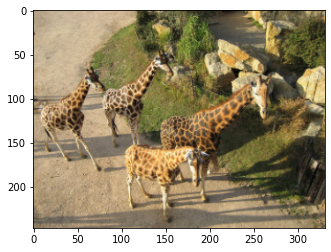

In [36]:
test_image('/home/bpanoel12/example.png')

<start> a group of people sitting on a sidewalk with a large umbrella . <end>


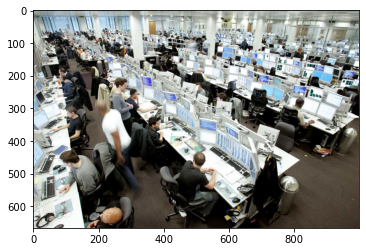

In [37]:
test_image('/home/bpanoel12/images/test_images/6.jpeg')

<start> a close up of a plate of food with a fork . <end>


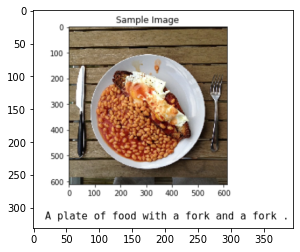

In [39]:
test_image('/home/bpanoel12/images/test_images/7.png')

<start> a person is sitting on a bench with a surfboard . <end>


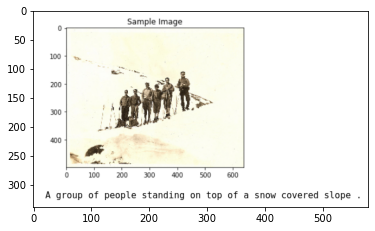

In [40]:
test_image('/home/bpanoel12/images/test_images/8.png')